In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from gplearn.genetic import SymbolicClassifier
from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

from joblib import Parallel, delayed


sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [60]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None, n_jobs=-1):
    
    def parallel_evalf(function, function_vars, data_point):
        function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            #print('te', te)
            #print('function_value', function_value)
            #print('function', function)
            #print('function_vars', function_vars, type(function_vars))
            function_value = np.inf        
            
        return function_value
    
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        function_values = parallel(delayed(parallel_evalf)(function, function_vars, data_point) for data_point in data_points)  
        function_values = np.array(function_values)

    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

In [4]:
def print_decision_tree_nodes(decision_tree): 
    
    n_nodes = decision_tree.tree_.node_count
    children_left = decision_tree.tree_.children_left
    children_right = decision_tree.tree_.children_right
    feature = decision_tree.tree_.feature
    threshold = decision_tree.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

## Load Histograms and Data Statistics

In [5]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [6]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000,-3.043901,-1.0,9.212087,110.625000,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.138240,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625000,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [7]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [8]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [9]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [10]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [11]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [12]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791476,4.517446,-1.396657,107.331233,-9.894227,-37.217121,-4.272182,0.000004,8.534652,106.621120,4.482172,2402.991829,[[ 1.77712398e+00 9.46578975e-02 8.42137846e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944794,6.939326,-0.547978,111.501253,-9.894227,-37.217121,-4.272182,0.000004,10.007755,117.621411,6.767623,2402.992395,[[8.73149553e+00 8.43511366e+00 3.84013568e+00...


In [13]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [14]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/xai/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [15]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [16]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447940e-01,6.939326e+00,-5.479782e-01,1.115013e+02,3.653952e-01
std,2.954910e+00,9.601276e+00,1.405716e+00,1.955450e+02,4.815408e-01
min,-9.894227e+00,-3.721712e+01,-4.272182e+00,4.127640e-06,0.000000e+00
25%,-3.370405e+00,1.604177e+00,-1.820977e+00,3.802474e+01,0.000000e+00
50%,-2.187935e+00,4.925814e+00,-9.364350e-01,7.603595e+01,0.000000e+00
75%,1.350188e+00,8.836291e+00,5.890964e-01,1.140709e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402992e+03,1.000000e+00


In [17]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [18]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

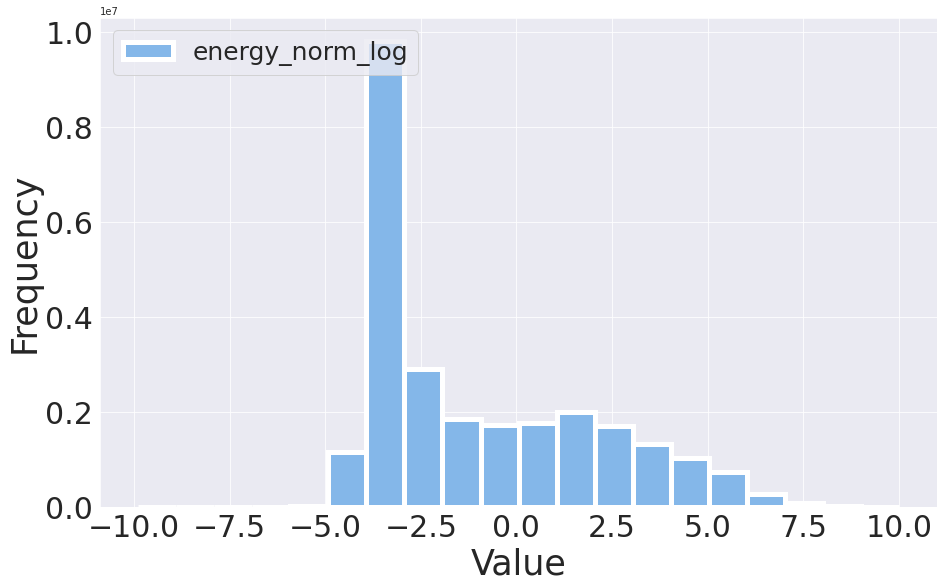

In [19]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

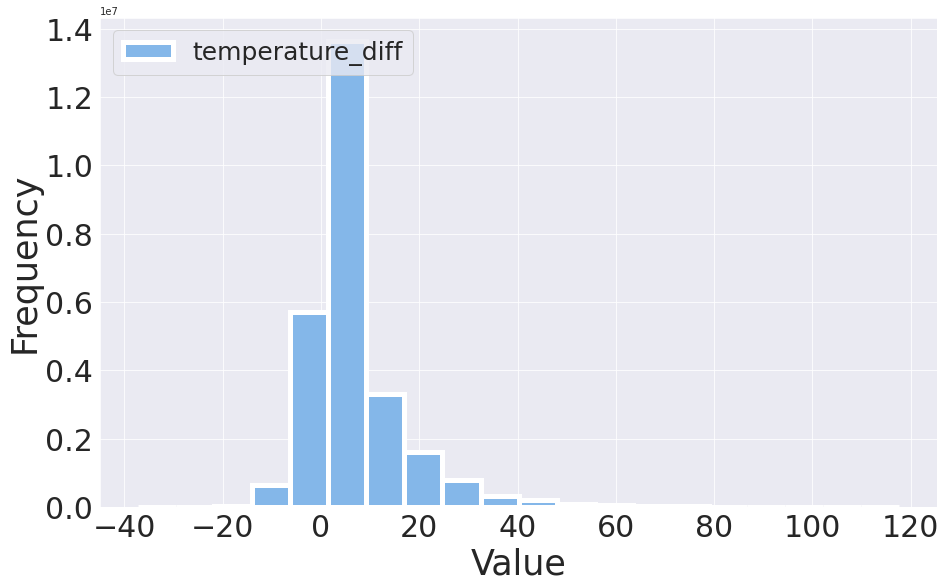

In [20]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

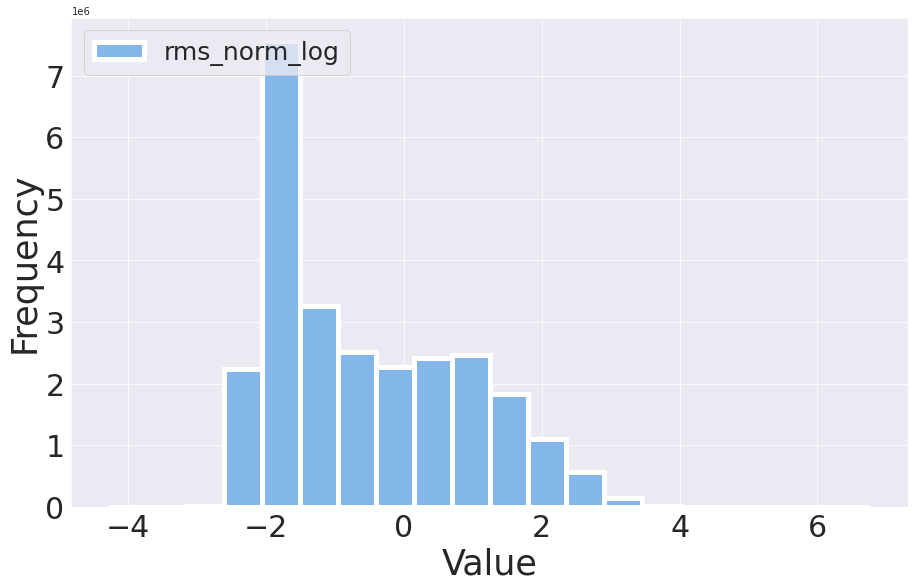

In [21]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

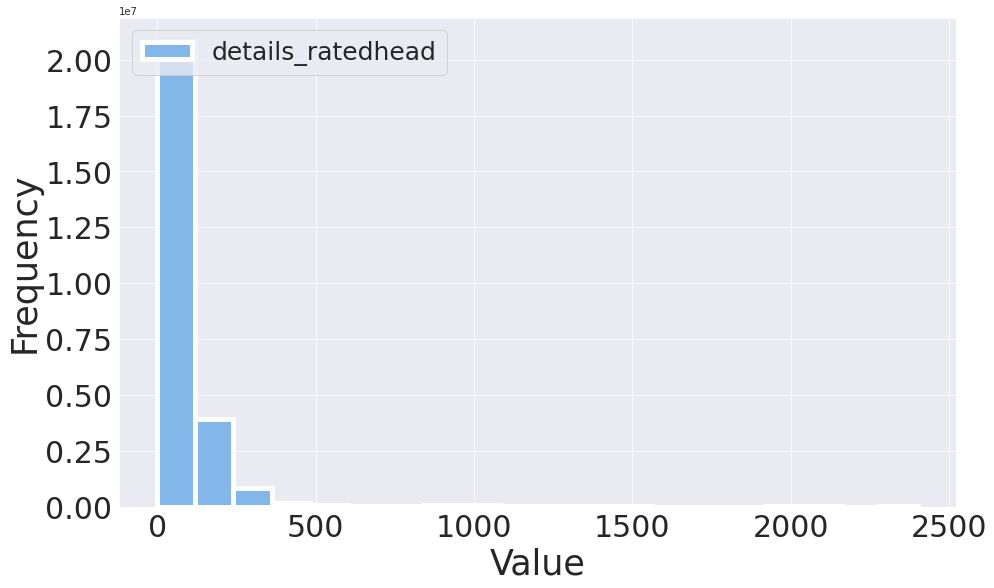

In [22]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [23]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [24]:
data= pump_data_replica.sample(n=100_000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1

In [25]:
X_data_scaled = np.empty_like(X_data.values.T)
scaler_list = []

for index, feature in enumerate(X_data.values.T):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    X_data_scaled[index] = feature_scaled
    
X_data_scaled = pd.DataFrame(data= X_data_scaled.T, index=X_data.index, columns=list(X_data.columns))

In [26]:
#X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
#X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)  


#X_data_scaled = data_scaled.values 
#X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
#X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

X_train_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)  


In [27]:
print(X_data.shape)
print(X_train.shape)
#print(X_valid.shape)
print(X_test.shape)
print()

print(X_data_scaled.shape)
print(X_train_scaled.shape)
#print(X_valid_scaled.shape)
print(X_test_scaled.shape)
print()

print(y_data.shape)
print(y_train.shape)
#print(y_valid.shape)
print(y_test.shape)

(100000, 4)
(75000, 4)
(25000, 4)

(100000, 4)
(75000, 4)
(25000, 4)

(100000, 1)
(75000, 1)
(25000, 1)


In [28]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.435427,2.008345,-1.831309,44.514913
13018525,-3.043470,4.328306,-2.011905,57.427111
22758968,0.059526,3.589398,0.421158,32.645146
26049008,-3.589604,2.368120,-2.103114,466.114163
4688620,0.485113,9.553305,1.172251,54.346425


In [29]:
X_data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,0.172689,0.185044,0.199485,0.018631
13018525,0.196928,0.202721,0.177614,0.024006
22758968,0.388817,0.197091,0.472272,0.013689
26049008,0.163155,0.187785,0.166568,0.194141
4688620,0.415135,0.242533,0.563233,0.022723


In [30]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [31]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.926955,6.885246,-0.541230,111.123051
std,2.960967,9.569454,1.407836,191.638943
min,-6.226325,-22.264112,-3.477683,0.001821
25%,-3.365552,1.560141,-1.820874,38.232625
50%,-2.161759,4.881958,-0.920437,76.627029
75%,1.371809,8.766879,0.598841,114.296520
max,9.942830,108.964905,4.778744,2401.895405


In [32]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 13880350 to 8425222
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   energy_norm_log    100000 non-null  float64
 1   temperature_diff   100000 non-null  float64
 2   rms_norm_log       100000 non-null  float64
 3   details_ratedhead  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


# Symbolic Metamodeling

In [33]:
metamodeling_hyperparams = {
    'num_iter': 100,#500,
    'batch_size': 128,
    'learning_rate': 0.001,        
    'dataset_size': 5000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 50,
    'restarts': 10,
}

symbolic_classification_hyperparams = {     
    'dataset_size': 5000,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True
symbolic_classification = True

In [34]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.90699

## Evaluate Model

In [35]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)
f1_random_forest = f1_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))
print('F1 Score: '+ str(f1_random_forest))


Accuracy: 0.90772
F1 Score: 0.8717834713499694


In [36]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train[:metamodeling_hyperparams['dataset_size']], 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [37]:
%load_ext autoreload 

In [38]:
if False:
    import pandas as pd
    from sklearn.preprocessing import MinMaxScaler
    from xgboost import XGBClassifier
    from sklearn.linear_model import LogisticRegression

    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split


    data          = pd.read_csv("data/absenteeism.csv", delimiter=';')

    feature_names = ['Transportation expense', 'Distance from Residence to Work',
                     'Service time', 'Age', 'Work load Average/day ', 'Hit target',
                     'Disciplinary failure', 'Education', 'Son', 'Social drinker',
                     'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index']

    scaler        = MinMaxScaler(feature_range=(0, 1))
    X             = scaler.fit_transform(data[feature_names])
    Y             = ((data['Absenteeism time in hours'] > 4) * 1) 

    X_train_abse, X_test_abse, Y_train_abse, Y_test_abse = train_test_split(X, Y, test_size=0.33, random_state=42)

    model         = XGBClassifier()

    model.fit(X_train_abse, Y_train_abse)

In [39]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]: 
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [40]:
#%autoreload 2
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled[:metamodeling_hyperparams['dataset_size']], #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]


restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.286
Iteration: 1 	--- Loss: 37.936
Iteration: 2 	--- Loss: 35.804
Iteration: 3 	--- Loss: 37.579
Iteration: 4 	--- Loss: 36.511
Iteration: 5 	--- Loss: 38.577
Iteration: 6 	--- Loss: 34.943
Iteration: 7 	--- Loss: 38.543
Iteration: 8 	--- Loss: 34.359
Iteration: 9 	--- Loss: 34.828
Iteration: 10 	--- Loss: 38.120
Iteration: 11 	--- Loss: 34.902
Iteration: 12 	--- Loss: 37.034
Iteration: 13 	--- Loss: 34.869
Iteration: 14 	--- Loss: 35.436
Iteration: 15 	--- Loss: 33.162
Iteration: 16 	--- Loss: 34.626
Iteration: 17 	--- Loss: 35.177
Iteration: 18 	--- Loss: 33.467
Iteration: 19 	--- Loss: 33.389
Iteration: 20 	--- Loss: 35.332
Iteration: 21 	--- Loss: 33.086
Iteration: 22 	--- Loss: 35.006
Iteration: 23 	--- Loss: 32.578
Iteration: 24 	--- Loss: 36.130
Iteration: 25 	--- Loss: 34.695
Iteration: 26 	--- Loss: 39.400
Iteration: 27 	--- Loss: 39.837
Iteration: 28 	--- Loss: 41.461
Iteration: 29 	--- Loss: 43.180
Iteration: 30 	--- Loss: 40.938
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [08:38<1:26:20, 518.07s/it]

Iteration: 127 	--- Loss: 31.867
Early Stopping requirement reached after 127 Iterations
New Global Minimum: 28.430032070654764


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.420
Iteration: 1 	--- Loss: 36.541
Iteration: 2 	--- Loss: 35.112
Iteration: 3 	--- Loss: 35.923
Iteration: 4 	--- Loss: 35.888
Iteration: 5 	--- Loss: 37.340
Iteration: 6 	--- Loss: 37.048
Iteration: 7 	--- Loss: 38.629
Iteration: 8 	--- Loss: 40.053
Iteration: 9 	--- Loss: 36.524
Iteration: 10 	--- Loss: 36.564
Iteration: 11 	--- Loss: 36.991
Iteration: 12 	--- Loss: 37.892
Iteration: 13 	--- Loss: 38.476
Iteration: 14 	--- Loss: 37.218
Iteration: 15 	--- Loss: 37.685
Iteration: 16 	--- Loss: 36.669
Iteration: 17 	--- Loss: 35.953
Iteration: 18 	--- Loss: 37.479
Iteration: 19 	--- Loss: 36.791
Iteration: 20 	--- Loss: 36.585
Iteration: 21 	--- Loss: 38.071
Iteration: 22 	--- Loss: 34.907
Iteration: 23 	--- Loss: 38.480
Iteration: 24 	--- Loss: 37.696
Iteration: 25 	--- Loss: 34.486
Iteration: 26 	--- Loss: 35.569
Iteration: 27 	--- Loss: 36.496
Iteration: 28 	--- Loss: 35.366
Iteration: 29 	--- Loss: 37.883
Iteration: 30 	--- Loss: 36.616
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [14:19<1:02:07, 414.18s/it]

Iteration: 92 	--- Loss: 36.613
Early Stopping requirement reached after 92 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 34.331
Iteration: 1 	--- Loss: 38.308
Iteration: 2 	--- Loss: 39.305
Iteration: 3 	--- Loss: 38.353
Iteration: 4 	--- Loss: 37.633
Iteration: 5 	--- Loss: 38.328
Iteration: 6 	--- Loss: 37.666
Iteration: 7 	--- Loss: 36.688
Iteration: 8 	--- Loss: 36.728
Iteration: 9 	--- Loss: 37.184
Iteration: 10 	--- Loss: 35.408
Iteration: 11 	--- Loss: 36.313
Iteration: 12 	--- Loss: 34.977
Iteration: 13 	--- Loss: 35.186
Iteration: 14 	--- Loss: 36.224
Iteration: 15 	--- Loss: 33.559
Iteration: 16 	--- Loss: 37.235
Iteration: 17 	--- Loss: 35.641
Iteration: 18 	--- Loss: 35.482
Iteration: 19 	--- Loss: 35.926
Iteration: 20 	--- Loss: 33.013
Iteration: 21 	--- Loss: 34.563
Iteration: 22 	--- Loss: 34.272
Iteration: 23 	--- Loss: 33.447
Iteration: 24 	--- Loss: 40.422
Iteration: 25 	--- Loss: 47.108
Iteration: 26 	--- Loss: 58.132
Iteration: 27 	--- Loss: 69.132
Iteration: 28 	--- Loss: 47.246
Iteration: 29 	--- Loss: 39.925
Iteration: 30 	--- Loss: 38.646
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [32:17<1:35:39, 717.42s/it]

Iteration: 338 	--- Loss: 14.536
Early Stopping requirement reached after 338 Iterations
New Global Minimum: 12.36602735613468


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.610
Iteration: 1 	--- Loss: 36.473
Iteration: 2 	--- Loss: 37.478
Iteration: 3 	--- Loss: 39.292
Iteration: 4 	--- Loss: 38.556
Iteration: 5 	--- Loss: 38.272
Iteration: 6 	--- Loss: 38.127
Iteration: 7 	--- Loss: 38.174
Iteration: 8 	--- Loss: 36.974
Iteration: 9 	--- Loss: 40.013
Iteration: 10 	--- Loss: 38.423
Iteration: 11 	--- Loss: 38.657
Iteration: 12 	--- Loss: 38.780
Iteration: 13 	--- Loss: 36.051
Iteration: 14 	--- Loss: 37.708
Iteration: 15 	--- Loss: 37.846
Iteration: 16 	--- Loss: 36.103
Iteration: 17 	--- Loss: 36.407
Iteration: 18 	--- Loss: 38.078
Iteration: 19 	--- Loss: 36.519
Iteration: 20 	--- Loss: 37.289
Iteration: 21 	--- Loss: 38.880
Iteration: 22 	--- Loss: 34.308
Iteration: 23 	--- Loss: 33.924
Iteration: 24 	--- Loss: 32.138
Iteration: 25 	--- Loss: 35.070
Iteration: 26 	--- Loss: 35.313
Iteration: 27 	--- Loss: 35.911
Iteration: 28 	--- Loss: 34.900
Iteration: 29 	--- Loss: 34.810
Iteration: 30 	--- Loss: 36.072
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [39:02<1:09:17, 593.86s/it]

Iteration: 109 	--- Loss: 29.764
Early Stopping requirement reached after 109 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.287
Iteration: 1 	--- Loss: 38.344
Iteration: 2 	--- Loss: 36.651
Iteration: 3 	--- Loss: 38.109
Iteration: 4 	--- Loss: 33.986
Iteration: 5 	--- Loss: 34.947
Iteration: 6 	--- Loss: 38.698
Iteration: 7 	--- Loss: 34.786
Iteration: 8 	--- Loss: 37.288
Iteration: 9 	--- Loss: 36.563
Iteration: 10 	--- Loss: 37.912
Iteration: 11 	--- Loss: 36.620
Iteration: 12 	--- Loss: 35.824
Iteration: 13 	--- Loss: 35.577
Iteration: 14 	--- Loss: 38.263
Iteration: 15 	--- Loss: 35.710
Iteration: 16 	--- Loss: 37.041
Iteration: 17 	--- Loss: 33.536
Iteration: 18 	--- Loss: 33.696
Iteration: 19 	--- Loss: 34.464
Iteration: 20 	--- Loss: 35.177
Iteration: 21 	--- Loss: 35.378
Iteration: 22 	--- Loss: 34.143
Iteration: 23 	--- Loss: 35.405
Iteration: 24 	--- Loss: 35.692
Iteration: 25 	--- Loss: 35.487
Iteration: 26 	--- Loss: 33.615
Iteration: 27 	--- Loss: 32.497
Iteration: 28 	--- Loss: 44.232
Iteration: 29 	--- Loss: 65.316
Iteration: 30 	--- Loss: 60.267
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [49:36<1:00:50, 608.47s/it]

Iteration: 185 	--- Loss: 16.835
Early Stopping requirement reached after 185 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.496
Iteration: 1 	--- Loss: 37.767
Iteration: 2 	--- Loss: 35.186
Iteration: 3 	--- Loss: 39.092
Iteration: 4 	--- Loss: 36.840
Iteration: 5 	--- Loss: 36.881
Iteration: 6 	--- Loss: 38.580
Iteration: 7 	--- Loss: 37.637
Iteration: 8 	--- Loss: 39.666
Iteration: 9 	--- Loss: 40.610
Iteration: 10 	--- Loss: 37.119
Iteration: 11 	--- Loss: 38.646
Iteration: 12 	--- Loss: 33.909
Iteration: 13 	--- Loss: 37.021
Wrong c Value: -0.031056434
te can't convert complex to float
function_value 7.74837555009394e-10 - 2.52003570121895e-10*I
function 2.84171294455551e-8*x**3.89991*exp(3.89991*I*pi)*hyper((1.0, 1.0), (5.42402,), 0.0310564339160919*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.9174543339052e-10 - 6.2362147338606e-11*I
function 2.84171294455551e-8*x**3.89991*exp(3.89991*I*pi)*hyper((1.0, 1.0), (5.42402,), 0.0310564339160919*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex


restart loop:  55%|█████▍    | 6/11 [50:21<34:44, 416.85s/it]  

 2.84171294455551e-8*x**3.89991*exp(3.89991*I*pi)*hyper((1.0, 1.0), (5.42402,), 0.0310564339160919*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.18366425257779e-11 - 1.03543607628741e-11*I
function 2.84171294455551e-8*x**3.89991*exp(3.89991*I*pi)*hyper((1.0, 1.0), (5.42402,), 0.0310564339160919*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.56394300443764e-9 - 8.33881613675153e-10*I
function 2.84171294455551e-8*x**3.89991*exp(3.89991*I*pi)*hyper((1.0, 1.0), (5.42402,), 0.0310564339160919*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.07871410806266e-9 - 2.30223898618645e-9*I
function 2.84171294455551e-8*x**3.89991*exp(3.89991*I*pi)*hyper((1.0, 1.0), (5.42402,), 0.0310564339160919*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.98119560883941e-10 - 1.94528857

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.987
Iteration: 1 	--- Loss: 39.585
Iteration: 2 	--- Loss: 37.808
Iteration: 3 	--- Loss: 38.075
Iteration: 4 	--- Loss: 36.933
Iteration: 5 	--- Loss: 38.942
Iteration: 6 	--- Loss: 35.483
Iteration: 7 	--- Loss: 36.898
Iteration: 8 	--- Loss: 37.390
Iteration: 9 	--- Loss: 37.161
Iteration: 10 	--- Loss: 38.471
Iteration: 11 	--- Loss: 37.031
Iteration: 12 	--- Loss: 38.268
Iteration: 13 	--- Loss: 36.529
Iteration: 14 	--- Loss: 38.690
Iteration: 15 	--- Loss: 36.512
Iteration: 16 	--- Loss: 37.924
Iteration: 17 	--- Loss: 38.922
Iteration: 18 	--- Loss: 34.999
Iteration: 19 	--- Loss: 37.355
Iteration: 20 	--- Loss: 36.230
Iteration: 21 	--- Loss: 36.985
Iteration: 22 	--- Loss: 38.540
Iteration: 23 	--- Loss: 37.609
Iteration: 24 	--- Loss: 35.994
Iteration: 25 	--- Loss: 38.440
Iteration: 26 	--- Loss: 38.335
Iteration: 27 	--- Loss: 38.411
Iteration: 28 	--- Loss: 36.468
Iteration: 29 	--- Loss: 36.656
Iteration: 30 	--- Loss: 37.796
Iteration: 31 	---


restart loop:  64%|██████▎   | 7/11 [59:01<30:02, 450.57s/it]

Iteration: 161 	--- Loss: 17.994
Early Stopping requirement reached after 161 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.735
Iteration: 1 	--- Loss: 38.192
Iteration: 2 	--- Loss: 37.488
Iteration: 3 	--- Loss: 36.397
Iteration: 4 	--- Loss: 37.066
Iteration: 5 	--- Loss: 39.880
Iteration: 6 	--- Loss: 36.902
Iteration: 7 	--- Loss: 38.361
Iteration: 8 	--- Loss: 34.295
Iteration: 9 	--- Loss: 38.260
Iteration: 10 	--- Loss: 38.452
Iteration: 11 	--- Loss: 38.636
Iteration: 12 	--- Loss: 34.937
Iteration: 13 	--- Loss: 34.957
Iteration: 14 	--- Loss: 35.915
Iteration: 15 	--- Loss: 31.668
Iteration: 16 	--- Loss: 35.322
Iteration: 17 	--- Loss: 33.559
Iteration: 18 	--- Loss: 35.372
Iteration: 19 	--- Loss: 35.541
Iteration: 20 	--- Loss: 34.138
Iteration: 21 	--- Loss: 34.827
Iteration: 22 	--- Loss: 35.103
Iteration: 23 	--- Loss: 33.781
Iteration: 24 	--- Loss: 55.696
Iteration: 25 	--- Loss: 78.739
Iteration: 26 	--- Loss: 124.356
Iteration: 27 	--- Loss: 54.815
Iteration: 28 	--- Loss: 36.578
Iteration: 29 	--- Loss: 48.313
Iteration: 30 	--- Loss: 41.167
Iteration: 31 	--


restart loop:  73%|███████▎  | 8/11 [1:05:41<21:43, 434.57s/it]

Iteration: 101 	--- Loss: 16.341
Early Stopping requirement reached after 101 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.600
Iteration: 1 	--- Loss: 37.554
Iteration: 2 	--- Loss: 35.642
Iteration: 3 	--- Loss: 36.029
Iteration: 4 	--- Loss: 36.695
Iteration: 5 	--- Loss: 38.802
Iteration: 6 	--- Loss: 37.384
Iteration: 7 	--- Loss: 35.992
Iteration: 8 	--- Loss: 38.172
Iteration: 9 	--- Loss: 36.119
Iteration: 10 	--- Loss: 39.270
Iteration: 11 	--- Loss: 35.999
Iteration: 12 	--- Loss: 37.414
Iteration: 13 	--- Loss: 35.699
Iteration: 14 	--- Loss: 37.439
Iteration: 15 	--- Loss: 36.878
Iteration: 16 	--- Loss: 37.481
Iteration: 17 	--- Loss: 39.216
Iteration: 18 	--- Loss: 39.787
Iteration: 19 	--- Loss: 35.651
Iteration: 20 	--- Loss: 40.006
Iteration: 21 	--- Loss: 35.783
Iteration: 22 	--- Loss: 37.314
Iteration: 23 	--- Loss: 36.531
Iteration: 24 	--- Loss: 38.226
Iteration: 25 	--- Loss: 37.898
Iteration: 26 	--- Loss: 36.883
Iteration: 27 	--- Loss: 36.401
Iteration: 28 	--- Loss: 36.720
Iteration: 29 	--- Loss: 38.558
Iteration: 30 	--- Loss: 38.445
Iteration: 31 	---


restart loop:  82%|████████▏ | 9/11 [1:15:41<16:12, 486.31s/it]

Iteration: 177 	--- Loss: 16.125
Early Stopping requirement reached after 177 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.321
Iteration: 1 	--- Loss: 33.768
Iteration: 2 	--- Loss: 35.304
Iteration: 3 	--- Loss: 36.395
Iteration: 4 	--- Loss: 38.173
Iteration: 5 	--- Loss: 35.860
Iteration: 6 	--- Loss: 34.943
Iteration: 7 	--- Loss: 37.410
Iteration: 8 	--- Loss: 37.188
Iteration: 9 	--- Loss: 34.767
Iteration: 10 	--- Loss: 34.018
Iteration: 11 	--- Loss: 34.720
Iteration: 12 	--- Loss: 36.063
Iteration: 13 	--- Loss: 32.716
Iteration: 14 	--- Loss: 33.044
Iteration: 15 	--- Loss: 34.553
Iteration: 16 	--- Loss: 34.267
Iteration: 17 	--- Loss: 42.767
Iteration: 18 	--- Loss: 71.666
Iteration: 19 	--- Loss: 137.715
Iteration: 20 	--- Loss: 81.705
Iteration: 21 	--- Loss: 35.809
Iteration: 22 	--- Loss: 52.997
Iteration: 23 	--- Loss: 43.727
Iteration: 24 	--- Loss: 40.464
Iteration: 25 	--- Loss: 37.627
Iteration: 26 	--- Loss: 38.440
Iteration: 27 	--- Loss: 38.586
Iteration: 28 	--- Loss: 40.459
Iteration: 29 	--- Loss: 40.720
Iteration: 30 	--- Loss: 41.681
Iteration: 31 	--


restart loop:  91%|█████████ | 10/11 [1:21:23<07:21, 441.60s/it]

Iteration: 88 	--- Loss: 20.526
Early Stopping requirement reached after 88 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.573
Iteration: 1 	--- Loss: 35.594
Iteration: 2 	--- Loss: 36.950
Iteration: 3 	--- Loss: 38.621
Iteration: 4 	--- Loss: 36.849
Iteration: 5 	--- Loss: 38.838
Iteration: 6 	--- Loss: 36.887
Iteration: 7 	--- Loss: 38.574
Iteration: 8 	--- Loss: 36.685
Iteration: 9 	--- Loss: 36.925
Iteration: 10 	--- Loss: 37.133
Iteration: 11 	--- Loss: 36.893
Iteration: 12 	--- Loss: 37.433
Wrong c Value: -0.02263888
te can't convert complex to float
function_value 1.84365525456162e-11 - 1.13611849902272e-11*I
function 1.34471689763383e-8*x**3.82421*exp(3.82421*I*pi)*hyper((1.0, 1.0), (5.299,), 0.0226388797163963*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.52438574055229e-11 - 9.39374557799154e-12*I
function 1.34471689763383e-8*x**3.82421*exp(3.82421*I*pi)*hyper((1.0, 1.0), (5.299,), 0.0226388797163963*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.12145632


restart loop: 100%|██████████| 11/11 [1:22:05<00:00, 447.73s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

te can't convert complex to float
function_value 1.02800356851512e-10 - 6.33488212268353e-11*I
function 1.34471689763383e-8*x**3.82421*exp(3.82421*I*pi)*hyper((1.0, 1.0), (5.299,), 0.0226388797163963*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.56157581318467e-10 - 4.65968143548865e-10*I
function 1.34471689763383e-8*x**3.82421*exp(3.82421*I*pi)*hyper((1.0, 1.0), (5.299,), 0.0226388797163963*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.10428107265757e-11 - 6.80492815380081e-12*I
function 1.34471689763383e-8*x**3.82421*exp(3.82421*I*pi)*hyper((1.0, 1.0), (5.299,), 0.0226388797163963*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.23610917113094e-11 - 1.37796097663622e-11*I
function 1.34471689763383e-8*x**3.82421*exp(3.82421*I*pi)*hyper((1.0, 1.0), (5.299,), 0.0226388797163963*x*exp_polar(2*I*pi))
function_vars [x]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.189
Iteration: 1 	--- Loss: 37.528
Iteration: 2 	--- Loss: 39.993
Iteration: 3 	--- Loss: 37.533
Iteration: 4 	--- Loss: 37.620
Iteration: 5 	--- Loss: 38.957
Iteration: 6 	--- Loss: 37.595
Iteration: 7 	--- Loss: 36.934
Iteration: 8 	--- Loss: 38.005
Iteration: 9 	--- Loss: 37.890
Iteration: 10 	--- Loss: 37.809
Iteration: 11 	--- Loss: 38.919
Iteration: 12 	--- Loss: 38.399
Iteration: 13 	--- Loss: 37.615
Iteration: 14 	--- Loss: 36.826
Iteration: 15 	--- Loss: 36.384
Iteration: 16 	--- Loss: 36.347
Wrong c Value: -0.009242784
te can't convert complex to float
function_value -2.11367534760341e-9 + 3.32614861995374e-10*I
function 1.7410152595223e-7*x**2.95032*exp(2.95032*I*pi)*hyper((1.0, 1.0), (3.9623,), 0.00924278423190117*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.96880084848566e-9 + 4.67180206094776e-10*I
function 1.7410152595223e-7*x**2.95032*exp(2.95032*I*pi)*hyper((1.0, 1.0), (3.9623,), 0.


restart loop:   9%|▉         | 1/11 [00:50<08:28, 50.89s/it]

te can't convert complex to float
function_value -1.16576841331964e-9 + 1.83449128246933e-10*I
function 1.7410152595223e-7*x**2.95032*exp(2.95032*I*pi)*hyper((1.0, 1.0), (3.9623,), 0.00924278423190117*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.81581488640348e-9 + 7.57832372721088e-10*I
function 1.7410152595223e-7*x**2.95032*exp(2.95032*I*pi)*hyper((1.0, 1.0), (3.9623,), 0.00924278423190117*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.58273686717152e-9 + 2.49064647154139e-10*I
function 1.7410152595223e-7*x**2.95032*exp(2.95032*I*pi)*hyper((1.0, 1.0), (3.9623,), 0.00924278423190117*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.19249124256574e-9 + 6.5974412657268e-10*I
function 1.7410152595223e-7*x**2.95032*exp(2.95032*I*pi)*hyper((1.0, 1.0), (3.9623,), 0.00924278423190117*x*exp_polar(2*I*pi))
function_vars 

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.143
Iteration: 1 	--- Loss: 37.644
Iteration: 2 	--- Loss: 38.364
Iteration: 3 	--- Loss: 39.617
Iteration: 4 	--- Loss: 36.388
Iteration: 5 	--- Loss: 38.172
Iteration: 6 	--- Loss: 37.693
Iteration: 7 	--- Loss: 38.271
Iteration: 8 	--- Loss: 37.996
Iteration: 9 	--- Loss: 37.173
Iteration: 10 	--- Loss: 36.492
Iteration: 11 	--- Loss: 35.860
Iteration: 12 	--- Loss: 37.824
Iteration: 13 	--- Loss: 36.106
Iteration: 14 	--- Loss: 40.397
Iteration: 15 	--- Loss: 38.262
Iteration: 16 	--- Loss: 37.947
Iteration: 17 	--- Loss: 39.085
Iteration: 18 	--- Loss: 36.962
Iteration: 19 	--- Loss: 38.296
Iteration: 20 	--- Loss: 37.409
Iteration: 21 	--- Loss: 38.314
Iteration: 22 	--- Loss: 37.769
Iteration: 23 	--- Loss: 39.013
Iteration: 24 	--- Loss: 37.874
Iteration: 25 	--- Loss: 39.195
Iteration: 26 	--- Loss: 35.378
Iteration: 27 	--- Loss: 37.802
Iteration: 28 	--- Loss: 42.673
Iteration: 29 	--- Loss: 36.458
Iteration: 30 	--- Loss: 39.405
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [06:29<33:02, 220.29s/it]

Iteration: 116 	--- Loss: 38.884
Early Stopping requirement reached after 116 Iterations
New Global Minimum: 34.77645732984001


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.075
Iteration: 1 	--- Loss: 38.487
Iteration: 2 	--- Loss: 36.766
Iteration: 3 	--- Loss: 40.741
Iteration: 4 	--- Loss: 36.894
Iteration: 5 	--- Loss: 37.530
Iteration: 6 	--- Loss: 36.758
Iteration: 7 	--- Loss: 38.826
Iteration: 8 	--- Loss: 35.960
Wrong c Value: -0.060226336
te can't convert complex to float
function_value -7.4923200325471e-7 - 4.53979099438809e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.0602263361215591*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.59938931538154e-7 - 5.21059298076118e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.0602263361215591*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.06185679167009e-7 - 1.24933249699421e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.060


restart loop:  27%|██▋       | 3/11 [07:00<17:49, 133.70s/it]

[x] <class 'list'>
te can't convert complex to float
function_value -5.00159526553073e-7 - 3.03059626996623e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.0602263361215591*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.29741748228755e-6 - 7.86138896425157e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.0602263361215591*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.11800954470545e-7 - 4.91891249483658e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.0602263361215591*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.77832538817006e-7 - 4.10716312444881e-7*I
function 0.000151489184671654*x**3.1734*exp(3.1734*I*pi)*hyper((1.0, 1.0), (1.43517,), 0.0602263361215591*x*exp_polar(2*I*pi)

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.239
Iteration: 1 	--- Loss: 40.156
Iteration: 2 	--- Loss: 38.053
Iteration: 3 	--- Loss: 35.857
Iteration: 4 	--- Loss: 36.647
Iteration: 5 	--- Loss: 38.498
Iteration: 6 	--- Loss: 38.579
Iteration: 7 	--- Loss: 34.537
Iteration: 8 	--- Loss: 36.889
Iteration: 9 	--- Loss: 35.806
Iteration: 10 	--- Loss: 36.235
Iteration: 11 	--- Loss: 36.699
Iteration: 12 	--- Loss: 37.457
Iteration: 13 	--- Loss: 36.128
Iteration: 14 	--- Loss: 35.431
Iteration: 15 	--- Loss: 36.617
Iteration: 16 	--- Loss: 36.199
Iteration: 17 	--- Loss: 36.396
Iteration: 18 	--- Loss: 33.557
Iteration: 19 	--- Loss: 32.333
Iteration: 20 	--- Loss: 32.909
Iteration: 21 	--- Loss: 33.238
Iteration: 22 	--- Loss: 29.042
Iteration: 23 	--- Loss: 31.211
Iteration: 24 	--- Loss: 26.898
Iteration: 25 	--- Loss: 29.215
Iteration: 26 	--- Loss: 29.049
Iteration: 27 	--- Loss: 29.865
Iteration: 28 	--- Loss: 29.448
Iteration: 29 	--- Loss: 29.486
Iteration: 30 	--- Loss: 29.352
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [11:56<23:03, 197.64s/it]

Iteration: 100 	--- Loss: 26.571
Early Stopping requirement reached after 100 Iterations
New Global Minimum: 25.30671976361223


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.675
Iteration: 1 	--- Loss: 37.864
Iteration: 2 	--- Loss: 37.550
Iteration: 3 	--- Loss: 37.705
Iteration: 4 	--- Loss: 37.014
Iteration: 5 	--- Loss: 39.286
Iteration: 6 	--- Loss: 36.187
Iteration: 7 	--- Loss: 35.691
Iteration: 8 	--- Loss: 38.676
Iteration: 9 	--- Loss: 37.689
Iteration: 10 	--- Loss: 37.479
Iteration: 11 	--- Loss: 37.154
Iteration: 12 	--- Loss: 37.242
Iteration: 13 	--- Loss: 36.648
Iteration: 14 	--- Loss: 36.367
Iteration: 15 	--- Loss: 35.991
Iteration: 16 	--- Loss: 33.923
Iteration: 17 	--- Loss: 32.709
Iteration: 18 	--- Loss: 31.807
Iteration: 19 	--- Loss: 29.139
Iteration: 20 	--- Loss: 44.548
Iteration: 21 	--- Loss: 27.371
Iteration: 22 	--- Loss: 30.378
Iteration: 23 	--- Loss: 31.450
Iteration: 24 	--- Loss: 34.998
Iteration: 25 	--- Loss: 33.223
Iteration: 26 	--- Loss: 31.857
Iteration: 27 	--- Loss: 32.769
Iteration: 28 	--- Loss: 34.589
Iteration: 29 	--- Loss: 33.850
Iteration: 30 	--- Loss: 33.908
Iteration: 31 	---


restart loop:  45%|████▌     | 5/11 [18:05<25:57, 259.67s/it]

Iteration: 125 	--- Loss: 25.993
Early Stopping requirement reached after 125 Iterations
New Global Minimum: 24.548159147532914


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.102
Iteration: 1 	--- Loss: 38.824
Iteration: 2 	--- Loss: 37.885
Iteration: 3 	--- Loss: 36.961
Iteration: 4 	--- Loss: 40.608
Iteration: 5 	--- Loss: 36.932
Iteration: 6 	--- Loss: 37.076
Iteration: 7 	--- Loss: 38.643
Iteration: 8 	--- Loss: 36.692
Iteration: 9 	--- Loss: 36.557
Iteration: 10 	--- Loss: 37.643
Iteration: 11 	--- Loss: 37.308
Iteration: 12 	--- Loss: 35.592
Iteration: 13 	--- Loss: 34.366
Iteration: 14 	--- Loss: 33.667
Iteration: 15 	--- Loss: 31.854
Iteration: 16 	--- Loss: 31.601
Iteration: 17 	--- Loss: 28.736
Iteration: 18 	--- Loss: 29.487
Iteration: 19 	--- Loss: 29.562
Iteration: 20 	--- Loss: 31.002
Iteration: 21 	--- Loss: 28.846
Iteration: 22 	--- Loss: 28.887
Iteration: 23 	--- Loss: 27.180
Iteration: 24 	--- Loss: 27.331
Iteration: 25 	--- Loss: 26.047
Iteration: 26 	--- Loss: 27.817
Iteration: 27 	--- Loss: 26.480
Iteration: 28 	--- Loss: 28.040
Iteration: 29 	--- Loss: 27.787
Iteration: 30 	--- Loss: 27.757
Iteration: 31 	---


restart loop:  55%|█████▍    | 6/11 [23:36<23:39, 283.82s/it]

Iteration: 112 	--- Loss: 28.582
Early Stopping requirement reached after 112 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.202
Iteration: 1 	--- Loss: 39.820
Iteration: 2 	--- Loss: 35.498
Iteration: 3 	--- Loss: 36.264
Iteration: 4 	--- Loss: 38.000
Iteration: 5 	--- Loss: 35.978
Iteration: 6 	--- Loss: 38.173
Iteration: 7 	--- Loss: 38.329
Iteration: 8 	--- Loss: 39.210
Iteration: 9 	--- Loss: 38.239
Iteration: 10 	--- Loss: 38.787
Iteration: 11 	--- Loss: 37.432
Iteration: 12 	--- Loss: 35.540
Iteration: 13 	--- Loss: 37.940
Iteration: 14 	--- Loss: 36.957
Iteration: 15 	--- Loss: 36.724
Iteration: 16 	--- Loss: 35.727
Iteration: 17 	--- Loss: 36.485
Iteration: 18 	--- Loss: 34.418
Iteration: 19 	--- Loss: 34.118
Iteration: 20 	--- Loss: 35.358
Iteration: 21 	--- Loss: 33.114
Iteration: 22 	--- Loss: 28.362
Iteration: 23 	--- Loss: 100.823
Iteration: 24 	--- Loss: 29.695
Iteration: 25 	--- Loss: 27.209
Iteration: 26 	--- Loss: 31.834
Iteration: 27 	--- Loss: 33.040
Iteration: 28 	--- Loss: 33.947
Iteration: 29 	--- Loss: 35.942
Iteration: 30 	--- Loss: 33.982
Iteration: 31 	--


restart loop:  64%|██████▎   | 7/11 [27:24<17:42, 265.60s/it]

Iteration: 76 	--- Loss: 34.680
Early Stopping requirement reached after 76 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.164
Iteration: 1 	--- Loss: 37.088
Iteration: 2 	--- Loss: 39.767
Iteration: 3 	--- Loss: 37.015
Iteration: 4 	--- Loss: 36.898
Iteration: 5 	--- Loss: 35.669
Iteration: 6 	--- Loss: 38.395
Iteration: 7 	--- Loss: 36.784
Iteration: 8 	--- Loss: 37.585
Iteration: 9 	--- Loss: 36.522
Iteration: 10 	--- Loss: 37.965
Iteration: 11 	--- Loss: 37.474
Iteration: 12 	--- Loss: 35.998
Iteration: 13 	--- Loss: 35.563
Iteration: 14 	--- Loss: 35.350
Iteration: 15 	--- Loss: 32.574
Iteration: 16 	--- Loss: 27.998
Iteration: 17 	--- Loss: 40.045
Iteration: 18 	--- Loss: 329.606
Iteration: 19 	--- Loss: 37.903
Iteration: 20 	--- Loss: 27.912
Iteration: 21 	--- Loss: 29.762
Iteration: 22 	--- Loss: 33.786
Iteration: 23 	--- Loss: 37.255
Iteration: 24 	--- Loss: 40.594
Iteration: 25 	--- Loss: 39.069
Iteration: 26 	--- Loss: 42.794
Iteration: 27 	--- Loss: 44.502
Iteration: 28 	--- Loss: 43.295
Iteration: 29 	--- Loss: 42.883
Iteration: 30 	--- Loss: 43.772
Iteration: 31 	--


restart loop:  73%|███████▎  | 8/11 [31:03<12:31, 250.62s/it]

Iteration: 71 	--- Loss: 40.853
Early Stopping requirement reached after 71 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.434
Iteration: 1 	--- Loss: 36.666
Iteration: 2 	--- Loss: 35.692
Iteration: 3 	--- Loss: 36.867
Iteration: 4 	--- Loss: 37.561
Iteration: 5 	--- Loss: 39.477
Iteration: 6 	--- Loss: 35.464
Wrong c Value: -0.056614995
te can't convert complex to float
function_value 5.90379684016944e-9 - 2.63023204346182e-8*I
function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 5.64529043643352e-8 - 2.51506347568184e-7*I
function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.67184428067681e-8 - 2.08137828278443e-7*I
function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'lis


restart loop:  82%|████████▏ | 9/11 [31:27<05:59, 179.98s/it]

function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.66668330368477e-8 - 7.42532975021659e-8*I
function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.41566216225968e-8 - 1.96724521976335e-7*I
function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.73972540621731e-8 - 2.11162036535883e-7*I
function 3.9801146127844e-5*x**3.57028*exp(3.57028*I*pi)*hyper((1.0, 1.0), (1.50967,), 0.0566149950027466*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.5157567368521e-8 - 1.120808212

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.499
Iteration: 1 	--- Loss: 38.930
Iteration: 2 	--- Loss: 36.930
Iteration: 3 	--- Loss: 36.787
Iteration: 4 	--- Loss: 36.998
Iteration: 5 	--- Loss: 36.214
Iteration: 6 	--- Loss: 37.128
Iteration: 7 	--- Loss: 37.529
Wrong c Value: -0.081154704
te can't convert complex to float
function_value 8.30166662376918e-8 + 2.79058428913382e-8*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.27079653042559e-7 + 4.27175047277595e-8*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 8.57111445516955e-9 + 2.88115849779864e-9*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*


restart loop:  91%|█████████ | 10/11 [31:55<02:12, 132.95s/it]

te can't convert complex to float
function_value 5.5362894912922e-8 + 1.86100974354499e-8*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.27492533576615e-8 + 7.64710411613609e-9*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.08239349354211e-8 + 2.3807287028311e-8*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.27079670595216e-8 + 1.09947005995727e-8*I
function 3.73804525380383e-5*x**4.10322*exp(4.10322*I*pi)*hyper((1.0, 1.0), (1.31418,), 0.0811547040939331*x*exp_polar(2*I*pi))
function_vars [x] <

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.067
Iteration: 1 	--- Loss: 37.284
Iteration: 2 	--- Loss: 35.481
Iteration: 3 	--- Loss: 40.099
Iteration: 4 	--- Loss: 36.631
Iteration: 5 	--- Loss: 37.194
Iteration: 6 	--- Loss: 38.969
Iteration: 7 	--- Loss: 38.142
Iteration: 8 	--- Loss: 36.429
Iteration: 9 	--- Loss: 35.287
Iteration: 10 	--- Loss: 39.393
Iteration: 11 	--- Loss: 35.485
Iteration: 12 	--- Loss: 38.617
Iteration: 13 	--- Loss: 35.150
Iteration: 14 	--- Loss: 34.956
Iteration: 15 	--- Loss: 36.222
Iteration: 16 	--- Loss: 37.056
Iteration: 17 	--- Loss: 37.293
Iteration: 18 	--- Loss: 34.209
Iteration: 19 	--- Loss: 35.940
Iteration: 20 	--- Loss: 35.856
Iteration: 21 	--- Loss: 37.017
Iteration: 22 	--- Loss: 36.413
Iteration: 23 	--- Loss: 35.440
Iteration: 24 	--- Loss: 33.898
Iteration: 25 	--- Loss: 32.070
Iteration: 26 	--- Loss: 28.234
Iteration: 27 	--- Loss: 41.302
Iteration: 28 	--- Loss: 28.887
Iteration: 29 	--- Loss: 31.077
Iteration: 30 	--- Loss: 29.930
Iteration: 31 	---


restart loop: 100%|██████████| 11/11 [41:20<00:00, 225.53s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

Iteration: 188 	--- Loss: 26.845
Early Stopping requirement reached after 188 Iterations
return abc -1.5882952 -0.06579637 1.144615


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.090
Iteration: 1 	--- Loss: 37.347
Iteration: 2 	--- Loss: 36.662
Iteration: 3 	--- Loss: 38.027
Iteration: 4 	--- Loss: 35.956
Iteration: 5 	--- Loss: 37.668
Iteration: 6 	--- Loss: 34.662
Iteration: 7 	--- Loss: 35.354
Iteration: 8 	--- Loss: 34.724
Iteration: 9 	--- Loss: 35.602
Iteration: 10 	--- Loss: 35.525
Iteration: 11 	--- Loss: 33.076
Iteration: 12 	--- Loss: 34.682
Iteration: 13 	--- Loss: 35.280
Iteration: 14 	--- Loss: 36.780
Iteration: 15 	--- Loss: 36.268
Iteration: 16 	--- Loss: 36.208
Iteration: 17 	--- Loss: 34.041
Iteration: 18 	--- Loss: 34.058
Iteration: 19 	--- Loss: 33.302
Iteration: 20 	--- Loss: 33.266
Iteration: 21 	--- Loss: 29.097
Iteration: 22 	--- Loss: 34.263
Iteration: 23 	--- Loss: 37.207
Iteration: 24 	--- Loss: 36.791
Iteration: 25 	--- Loss: 41.050
Iteration: 26 	--- Loss: 42.694
Iteration: 27 	--- Loss: 49.058
Iteration: 28 	--- Loss: 52.004
Iteration: 29 	--- Loss: 53.305
Iteration: 30 	--- Loss: 55.783
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [05:09<51:32, 309.30s/it]

Iteration: 72 	--- Loss: 35.746
Early Stopping requirement reached after 72 Iterations
New Global Minimum: 29.096678490494703


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.997
Iteration: 1 	--- Loss: 35.585
Iteration: 2 	--- Loss: 36.954
Iteration: 3 	--- Loss: 37.420
Iteration: 4 	--- Loss: 37.223
Iteration: 5 	--- Loss: 37.106
Iteration: 6 	--- Loss: 37.160
Iteration: 7 	--- Loss: 35.750
Iteration: 8 	--- Loss: 38.088
Iteration: 9 	--- Loss: 36.945
Iteration: 10 	--- Loss: 38.481
Iteration: 11 	--- Loss: 36.481
Iteration: 12 	--- Loss: 36.586
Iteration: 13 	--- Loss: 37.662
Iteration: 14 	--- Loss: 37.669
Iteration: 15 	--- Loss: 38.671
Iteration: 16 	--- Loss: 37.961
Iteration: 17 	--- Loss: 37.719
Iteration: 18 	--- Loss: 37.225
Iteration: 19 	--- Loss: 38.196
Iteration: 20 	--- Loss: 37.487
Iteration: 21 	--- Loss: 36.601
Iteration: 22 	--- Loss: 35.997
Iteration: 23 	--- Loss: 37.209
Iteration: 24 	--- Loss: 39.863
Iteration: 25 	--- Loss: 38.026
Iteration: 26 	--- Loss: 38.728
Iteration: 27 	--- Loss: 37.127
Iteration: 28 	--- Loss: 39.710
Iteration: 29 	--- Loss: 37.477
Iteration: 30 	--- Loss: 38.105
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [13:38<1:04:03, 427.08s/it]

Iteration: 137 	--- Loss: 36.289
Early Stopping requirement reached after 137 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.196
Iteration: 1 	--- Loss: 38.424
Iteration: 2 	--- Loss: 37.791
Iteration: 3 	--- Loss: 36.800
Iteration: 4 	--- Loss: 36.542
Iteration: 5 	--- Loss: 38.029
Iteration: 6 	--- Loss: 39.584
Iteration: 7 	--- Loss: 38.768
Iteration: 8 	--- Loss: 36.127
Iteration: 9 	--- Loss: 38.112
Iteration: 10 	--- Loss: 38.370
Iteration: 11 	--- Loss: 39.243
Iteration: 12 	--- Loss: 34.493
Iteration: 13 	--- Loss: 35.453
Iteration: 14 	--- Loss: 34.189
Iteration: 15 	--- Loss: 36.483
Iteration: 16 	--- Loss: 36.570
Iteration: 17 	--- Loss: 38.249
Iteration: 18 	--- Loss: 33.389
Iteration: 19 	--- Loss: 33.706
Iteration: 20 	--- Loss: 34.166
Iteration: 21 	--- Loss: 40.323
Iteration: 22 	--- Loss: 59.888
Iteration: 23 	--- Loss: 70.798
Iteration: 24 	--- Loss: 88.035
Iteration: 25 	--- Loss: 75.741
Iteration: 26 	--- Loss: 56.607
Iteration: 27 	--- Loss: 38.020
Iteration: 28 	--- Loss: 46.484
Iteration: 29 	--- Loss: 45.639
Iteration: 30 	--- Loss: 43.233
Iteration: 31 	---


restart loop:  27%|██▋       | 3/11 [23:18<1:06:15, 496.98s/it]

Iteration: 143 	--- Loss: 13.736
Early Stopping requirement reached after 143 Iterations
New Global Minimum: 12.973158543056972


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.028
Iteration: 1 	--- Loss: 38.044
Iteration: 2 	--- Loss: 38.031
Iteration: 3 	--- Loss: 39.080
Iteration: 4 	--- Loss: 38.304
Iteration: 5 	--- Loss: 38.400
Iteration: 6 	--- Loss: 36.867
Iteration: 7 	--- Loss: 40.100
Iteration: 8 	--- Loss: 38.532
Iteration: 9 	--- Loss: 38.187
Iteration: 10 	--- Loss: 38.318
Iteration: 11 	--- Loss: 38.380
Iteration: 12 	--- Loss: 37.313
Iteration: 13 	--- Loss: 36.437
Iteration: 14 	--- Loss: 40.000
Iteration: 15 	--- Loss: 37.136
Iteration: 16 	--- Loss: 37.710
Iteration: 17 	--- Loss: 36.159
Iteration: 18 	--- Loss: 38.100
Iteration: 19 	--- Loss: 38.049
Iteration: 20 	--- Loss: 39.660
Iteration: 21 	--- Loss: 38.614
Iteration: 22 	--- Loss: 38.087
Iteration: 23 	--- Loss: 37.776
Iteration: 24 	--- Loss: 36.701
Iteration: 25 	--- Loss: 35.920
Iteration: 26 	--- Loss: 37.037
Iteration: 27 	--- Loss: 37.399
Iteration: 28 	--- Loss: 38.009
Iteration: 29 	--- Loss: 38.246
Iteration: 30 	--- Loss: 38.371
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [27:30<46:39, 399.99s/it]  

Iteration: 85 	--- Loss: 36.293
Early Stopping requirement reached after 85 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.252
Iteration: 1 	--- Loss: 37.899
Iteration: 2 	--- Loss: 35.325
Iteration: 3 	--- Loss: 35.212
Iteration: 4 	--- Loss: 38.627
Iteration: 5 	--- Loss: 37.291
Iteration: 6 	--- Loss: 35.174
Iteration: 7 	--- Loss: 37.181
Iteration: 8 	--- Loss: 36.651
Iteration: 9 	--- Loss: 35.160
Iteration: 10 	--- Loss: 37.325
Iteration: 11 	--- Loss: 38.947
Iteration: 12 	--- Loss: 38.055
Wrong c Value: -0.0025847629
te can't convert complex to float
function_value 4.30440854744982e-13 - 1.18546522508658e-12*I
function 3.39607542073971e-11*x**3.61087*exp(3.61087*I*pi)*hyper((1.0, 1.0), (4.59857,), 0.00258476287126541*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.22038766891686e-14 - 6.1151081239058e-14*I
function 3.39607542073971e-11*x**3.61087*exp(3.61087*I*pi)*hyper((1.0, 1.0), (4.59857,), 0.00258476287126541*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6


restart loop:  45%|████▌     | 5/11 [28:12<27:06, 271.09s/it]

BREAK tune_single_dim
func_true 1.7976931348623157e+308
y[batch_index] 0.5616168331263335
a_new, b_new, c_new nan nan nan
best_parameters abc 3.3222377 0.26883483 0.19722551


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.306
Iteration: 1 	--- Loss: 38.241
Iteration: 2 	--- Loss: 34.843
Iteration: 3 	--- Loss: 35.887
Iteration: 4 	--- Loss: 36.353
Iteration: 5 	--- Loss: 37.761
Iteration: 6 	--- Loss: 37.796
Iteration: 7 	--- Loss: 36.808
Iteration: 8 	--- Loss: 38.895
Iteration: 9 	--- Loss: 39.614
Iteration: 10 	--- Loss: 38.241
Iteration: 11 	--- Loss: 39.208
Iteration: 12 	--- Loss: 35.066
Iteration: 13 	--- Loss: 37.977
Iteration: 14 	--- Loss: 39.604
Iteration: 15 	--- Loss: 36.751
Iteration: 16 	--- Loss: 36.665
Iteration: 17 	--- Loss: 37.120
Wrong c Value: -0.03447766
te can't convert complex to float
function_value 2.23035946625758e-10 - 4.39528154553342e-11*I
function 3.26299868918167e-8*x**3.93807*exp(3.93807*I*pi)*hyper((1.0, 1.0), (5.51179,), 0.0344776585698128*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.58340075057931e-9 - 9.03232731744719e-10*I
function 3.26299868918167e-8*x**3.93807*exp(3.93807*I*pi)


restart loop:  55%|█████▍    | 6/11 [29:10<16:31, 198.37s/it]

te can't convert complex to float
function_value 6.63870370989103e-9 - 1.3082631900278e-9*I
function 3.26299868918167e-8*x**3.93807*exp(3.93807*I*pi)*hyper((1.0, 1.0), (5.51179,), 0.0344776585698128*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.15727201483036e-9 - 4.25125098394545e-10*I
function 3.26299868918167e-8*x**3.93807*exp(3.93807*I*pi)*hyper((1.0, 1.0), (5.51179,), 0.0344776585698128*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.93259676651476e-11 - 1.36617953704186e-11*I
function 3.26299868918167e-8*x**3.93807*exp(3.93807*I*pi)*hyper((1.0, 1.0), (5.51179,), 0.0344776585698128*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.37057727964284e-11 - 6.64226387680303e-12*I
function 3.26299868918167e-8*x**3.93807*exp(3.93807*I*pi)*hyper((1.0, 1.0), (5.51179,), 0.0344776585698128*x*exp_polar(2*I*pi))
function_vars

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.168
Iteration: 1 	--- Loss: 36.490
Iteration: 2 	--- Loss: 34.795
Iteration: 3 	--- Loss: 35.118
Iteration: 4 	--- Loss: 37.727
Iteration: 5 	--- Loss: 36.209
Iteration: 6 	--- Loss: 37.888
Iteration: 7 	--- Loss: 38.741
Iteration: 8 	--- Loss: 34.272
Iteration: 9 	--- Loss: 36.497
Iteration: 10 	--- Loss: 32.736
Iteration: 11 	--- Loss: 36.437
Iteration: 12 	--- Loss: 35.427
Iteration: 13 	--- Loss: 35.625
Iteration: 14 	--- Loss: 36.821
Iteration: 15 	--- Loss: 36.881
Iteration: 16 	--- Loss: 33.177
Iteration: 17 	--- Loss: 33.169
Iteration: 18 	--- Loss: 36.680
Iteration: 19 	--- Loss: 45.650
Iteration: 20 	--- Loss: 82.789
Iteration: 21 	--- Loss: 116.735
Iteration: 22 	--- Loss: 168.103
Iteration: 23 	--- Loss: 125.468
Iteration: 24 	--- Loss: 44.447
Iteration: 25 	--- Loss: 51.863
Iteration: 26 	--- Loss: 52.004
Iteration: 27 	--- Loss: 40.605
Iteration: 28 	--- Loss: 37.458
Iteration: 29 	--- Loss: 39.275
Iteration: 30 	--- Loss: 36.848
Iteration: 31 	


restart loop:  64%|██████▎   | 7/11 [38:36<21:14, 318.61s/it]

Iteration: 129 	--- Loss: 15.795
Early Stopping requirement reached after 129 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.328
Iteration: 1 	--- Loss: 36.802
Iteration: 2 	--- Loss: 36.892
Iteration: 3 	--- Loss: 37.491
Iteration: 4 	--- Loss: 36.474
Iteration: 5 	--- Loss: 39.403
Iteration: 6 	--- Loss: 39.137
Iteration: 7 	--- Loss: 37.762
Iteration: 8 	--- Loss: 37.400
Iteration: 9 	--- Loss: 36.418
Iteration: 10 	--- Loss: 37.072
Iteration: 11 	--- Loss: 36.517
Iteration: 12 	--- Loss: 34.994
Iteration: 13 	--- Loss: 35.697
Iteration: 14 	--- Loss: 35.672
Iteration: 15 	--- Loss: 35.627
Iteration: 16 	--- Loss: 36.590
Iteration: 17 	--- Loss: 34.211
Iteration: 18 	--- Loss: 31.696
Iteration: 19 	--- Loss: 36.112
Iteration: 20 	--- Loss: 32.874
Iteration: 21 	--- Loss: 37.201
Iteration: 22 	--- Loss: 53.615
Iteration: 23 	--- Loss: 71.514
Iteration: 24 	--- Loss: 146.618
Iteration: 25 	--- Loss: 175.755
Iteration: 26 	--- Loss: 110.563
Iteration: 27 	--- Loss: 37.668
Iteration: 28 	--- Loss: 55.873
Iteration: 29 	--- Loss: 47.182
Iteration: 30 	--- Loss: 39.069
Iteration: 31 	


restart loop:  73%|███████▎  | 8/11 [1:14:52<45:30, 910.03s/it]

Iteration: 499 	--- Loss: 16.779


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.201
Iteration: 1 	--- Loss: 36.957
Iteration: 2 	--- Loss: 39.662
Iteration: 3 	--- Loss: 36.334
Iteration: 4 	--- Loss: 37.394
Iteration: 5 	--- Loss: 36.885
Iteration: 6 	--- Loss: 40.269
Wrong c Value: -0.12179543
te can't convert complex to float
function_value -2.74817933773882e-6 - 1.39049965659874e-6*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.88525642155874e-5 - 9.53885494581625e-6*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.60094100275188e-6 - 1.82197251795024e-6*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list


restart loop:  82%|████████▏ | 9/11 [1:15:17<21:06, 633.36s/it]

te can't convert complex to float
function_value -1.3364988797123e-6 - 6.76229970789909e-7*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.92353525479772e-5 - 1.47922470416189e-5*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.22271726233357e-6 - 1.63060218998544e-6*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.1257117406056e-6 - 5.69577744525644e-7*I
function 0.000197339030130051*x**3.1491*exp(3.1491*I*pi)*hyper((1.0, 1.0), (4.08569,), 0.121795430779457*x*exp_polar(2*I*pi))
function_vars [x] <clas

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.612
Iteration: 1 	--- Loss: 37.566
Iteration: 2 	--- Loss: 36.443
Iteration: 3 	--- Loss: 37.831
Iteration: 4 	--- Loss: 37.868
Iteration: 5 	--- Loss: 38.034
Iteration: 6 	--- Loss: 38.354
Iteration: 7 	--- Loss: 36.899
Iteration: 8 	--- Loss: 38.183
Iteration: 9 	--- Loss: 38.608
Iteration: 10 	--- Loss: 36.158
Iteration: 11 	--- Loss: 36.445
Iteration: 12 	--- Loss: 36.087
Iteration: 13 	--- Loss: 35.011
Iteration: 14 	--- Loss: 36.821
Iteration: 15 	--- Loss: 33.684
Iteration: 16 	--- Loss: 33.399
Iteration: 17 	--- Loss: 38.216
Iteration: 18 	--- Loss: 35.128
Iteration: 19 	--- Loss: 58.070
Iteration: 20 	--- Loss: 102.201
Iteration: 21 	--- Loss: 145.781
Iteration: 22 	--- Loss: 75.427
Iteration: 23 	--- Loss: 35.666
Iteration: 24 	--- Loss: 47.544
Iteration: 25 	--- Loss: 41.553
Iteration: 26 	--- Loss: 35.307
Iteration: 27 	--- Loss: 36.058
Iteration: 28 	--- Loss: 38.557
Iteration: 29 	--- Loss: 39.712
Iteration: 30 	--- Loss: 41.439
Iteration: 31 	-


restart loop:  91%|█████████ | 10/11 [1:27:51<11:10, 670.68s/it]

Iteration: 187 	--- Loss: 13.941
Early Stopping requirement reached after 187 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.618
Iteration: 1 	--- Loss: 38.050
Iteration: 2 	--- Loss: 36.653
Iteration: 3 	--- Loss: 36.197
Iteration: 4 	--- Loss: 37.566
Iteration: 5 	--- Loss: 38.119
Iteration: 6 	--- Loss: 35.733
Iteration: 7 	--- Loss: 35.975
Iteration: 8 	--- Loss: 37.086
Wrong c Value: -0.029067658
te can't convert complex to float
function_value -4.39769485473426e-11 - 4.06335338033725e-10*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,), 0.0290676578879356*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.49672355986087e-10 - 2.30690633430531e-9*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,), 0.0290676578879356*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.67372634220037e-11 - 3.3944256807504e-10*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,


restart loop: 100%|██████████| 11/11 [1:28:22<00:00, 482.08s/it]

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]

te can't convert complex to float
function_value -1.68127764440925e-10 - 1.5534559412055e-9*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,), 0.0290676578879356*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.69330271614615e-10 - 1.56456678848002e-9*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,), 0.0290676578879356*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.59333305768261e-9 - 2.39617094736141e-8*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,), 0.0290676578879356*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.77860796385389e-9 - 2.56736004554822e-8*I
function 1.51116183038457e-7*x**3.46568*exp(3.46568*I*pi)*hyper((1.0, 1.0), (5.17384,), 0.0290676578879356*x*exp_polar(2*I*pi))
function_var

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.470
Iteration: 1 	--- Loss: 37.500
Iteration: 2 	--- Loss: 35.844
Iteration: 3 	--- Loss: 36.719
Iteration: 4 	--- Loss: 37.730
Iteration: 5 	--- Loss: 39.554
Iteration: 6 	--- Loss: 39.023
Iteration: 7 	--- Loss: 36.039
Iteration: 8 	--- Loss: 38.860
Iteration: 9 	--- Loss: 38.521
Iteration: 10 	--- Loss: 37.391
Iteration: 11 	--- Loss: 37.061
Iteration: 12 	--- Loss: 37.727
Iteration: 13 	--- Loss: 38.072
Iteration: 14 	--- Loss: 37.395
Iteration: 15 	--- Loss: 37.213
Iteration: 16 	--- Loss: 37.351
Iteration: 17 	--- Loss: 38.712
Iteration: 18 	--- Loss: 36.690
Iteration: 19 	--- Loss: 38.392
Iteration: 20 	--- Loss: 37.439
Iteration: 21 	--- Loss: 36.082
Iteration: 22 	--- Loss: 37.425
Iteration: 23 	--- Loss: 37.971
Iteration: 24 	--- Loss: 35.977
Iteration: 25 	--- Loss: 36.964
Iteration: 26 	--- Loss: 36.525
Iteration: 27 	--- Loss: 36.062
Iteration: 28 	--- Loss: 35.788
Iteration: 29 	--- Loss: 36.960
Iteration: 30 	--- Loss: 36.254
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [05:19<53:18, 319.87s/it]

Iteration: 110 	--- Loss: 36.671
Early Stopping requirement reached after 110 Iterations
New Global Minimum: 35.07573810092674


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.157
Iteration: 1 	--- Loss: 37.715
Iteration: 2 	--- Loss: 37.432
Iteration: 3 	--- Loss: 37.819
Iteration: 4 	--- Loss: 36.459
Iteration: 5 	--- Loss: 38.605
Iteration: 6 	--- Loss: 36.378
Iteration: 7 	--- Loss: 37.785
Iteration: 8 	--- Loss: 39.673
Iteration: 9 	--- Loss: 37.851
Iteration: 10 	--- Loss: 40.286
Iteration: 11 	--- Loss: 37.556
Iteration: 12 	--- Loss: 38.068
Iteration: 13 	--- Loss: 37.426
Iteration: 14 	--- Loss: 35.053
Iteration: 15 	--- Loss: 38.346
Iteration: 16 	--- Loss: 38.618
Iteration: 17 	--- Loss: 38.096
Iteration: 18 	--- Loss: 38.455
Iteration: 19 	--- Loss: 37.943
Iteration: 20 	--- Loss: 36.458
Iteration: 21 	--- Loss: 38.250
Iteration: 22 	--- Loss: 37.620
Iteration: 23 	--- Loss: 37.103
Iteration: 24 	--- Loss: 36.000
Iteration: 25 	--- Loss: 36.875
Iteration: 26 	--- Loss: 36.657
Iteration: 27 	--- Loss: 38.717
Iteration: 28 	--- Loss: 35.697
Iteration: 29 	--- Loss: 36.764
Iteration: 30 	--- Loss: 36.689
Iteration: 31 	---


restart loop:  18%|█▊        | 2/11 [10:22<46:27, 309.78s/it]

Iteration: 102 	--- Loss: 441.286
Early Stopping requirement reached after 102 Iterations
New Global Minimum: 34.95171555808997


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.860
Iteration: 1 	--- Loss: 37.946
Iteration: 2 	--- Loss: 35.514
Iteration: 3 	--- Loss: 38.693
Iteration: 4 	--- Loss: 38.507
Iteration: 5 	--- Loss: 37.526
Iteration: 6 	--- Loss: 35.535
Wrong c Value: -0.13004057
te can't convert complex to float
function_value -2.07517114852521e-8 + 1.67178407914817e-7*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.12048066805273e-10 + 4.93073650568845e-9*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.14489526628056e-8 + 4.1447925879103e-7*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] <class 'l


restart loop:  27%|██▋       | 3/11 [10:47<23:56, 179.57s/it]

te can't convert complex to float
function_value -6.50826357763848e-9 + 5.2431393139445e-8*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.85317866996441e-7 + 2.29855676183698e-6*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.91202985258842e-7 + 2.34596801763619e-6*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.19732844652157e-8 + 1.77019554081831e-7*I
function 0.00624152205388652*x**2.53931*exp(2.53931*I*pi)*hyper((1.0, 1.0), (1.66044,), 0.130040571093559*x*exp_polar(2*I*pi))
function_vars [x] 

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.799
Iteration: 1 	--- Loss: 38.597
Iteration: 2 	--- Loss: 36.965
Iteration: 3 	--- Loss: 37.000
Iteration: 4 	--- Loss: 37.299
Iteration: 5 	--- Loss: 35.109
Iteration: 6 	--- Loss: 37.033
Iteration: 7 	--- Loss: 35.527
Iteration: 8 	--- Loss: 40.077
Iteration: 9 	--- Loss: 36.411
Iteration: 10 	--- Loss: 36.267
Iteration: 11 	--- Loss: 36.688
Iteration: 12 	--- Loss: 36.206
Iteration: 13 	--- Loss: 37.784
Iteration: 14 	--- Loss: 36.023
Iteration: 15 	--- Loss: 38.408
Iteration: 16 	--- Loss: 37.508
Iteration: 17 	--- Loss: 39.007
Iteration: 18 	--- Loss: 35.820
Iteration: 19 	--- Loss: 40.326
Iteration: 20 	--- Loss: 38.236
Iteration: 21 	--- Loss: 36.374
Iteration: 22 	--- Loss: 35.183
Iteration: 23 	--- Loss: 39.719
Iteration: 24 	--- Loss: 37.647
Iteration: 25 	--- Loss: 36.846
Iteration: 26 	--- Loss: 36.287
Iteration: 27 	--- Loss: 40.011
Iteration: 28 	--- Loss: 38.386
Iteration: 29 	--- Loss: 37.693
Iteration: 30 	--- Loss: 38.702
Iteration: 31 	---


restart loop:  36%|███▋      | 4/11 [13:33<20:19, 174.17s/it]

Iteration: 56 	--- Loss: 36.092
Early Stopping requirement reached after 56 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.610
Iteration: 1 	--- Loss: 39.115
Iteration: 2 	--- Loss: 35.338
Iteration: 3 	--- Loss: 36.523
Iteration: 4 	--- Loss: 38.981
Iteration: 5 	--- Loss: 35.158
Iteration: 6 	--- Loss: 37.936
Iteration: 7 	--- Loss: 39.214
Iteration: 8 	--- Loss: 39.448
Iteration: 9 	--- Loss: 36.863
Iteration: 10 	--- Loss: 37.595
Iteration: 11 	--- Loss: 37.999
Iteration: 12 	--- Loss: 39.779
Wrong c Value: -0.04041855
te can't convert complex to float
function_value -4.31983115444386e-11 - 2.35799346754635e-10*I
function 1.72941860039346e-5*x**3.44233*exp(3.44233*I*pi)*hyper((1.0, 1.0), (1.18034,), 0.0404185503721237*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.25442394810863e-11 - 2.86814389321991e-10*I
function 1.72941860039346e-5*x**3.44233*exp(3.44233*I*pi)*hyper((1.0, 1.0), (1.18034,), 0.0404185503721237*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -2.8


restart loop:  45%|████▌     | 5/11 [14:15<12:39, 126.66s/it]

te can't convert complex to float
function_value -3.46516350437238e-10 - 1.89147043371931e-9*I
function 1.72941860039346e-5*x**3.44233*exp(3.44233*I*pi)*hyper((1.0, 1.0), (1.18034,), 0.0404185503721237*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.55225129206295e-12 - 8.47301266140818e-12*I
function 1.72941860039346e-5*x**3.44233*exp(3.44233*I*pi)*hyper((1.0, 1.0), (1.18034,), 0.0404185503721237*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.58051912897868e-9 - 8.62731354124784e-9*I
function 1.72941860039346e-5*x**3.44233*exp(3.44233*I*pi)*hyper((1.0, 1.0), (1.18034,), 0.0404185503721237*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.45422517719531e-11 - 7.93793402003798e-11*I
function 1.72941860039346e-5*x**3.44233*exp(3.44233*I*pi)*hyper((1.0, 1.0), (1.18034,), 0.0404185503721237*x*exp_polar(2*I*pi))
function

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 39.969
Iteration: 1 	--- Loss: 36.764
Iteration: 2 	--- Loss: 38.029
Iteration: 3 	--- Loss: 38.235
Iteration: 4 	--- Loss: 39.161
Iteration: 5 	--- Loss: 36.239
Wrong c Value: -0.22121747
te can't convert complex to float
function_value 1.74866035321861e-7 + 1.80722601888494e-7*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.83956406135374e-5 + 1.90117424974209e-5*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.05752427161787e-5 + 1.09294259216914e-5*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to flo


restart loop:  55%|█████▍    | 6/11 [14:37<07:34, 90.96s/it] 

te can't convert complex to float
function_value 0.000791757596195198 + 0.000818274930211604*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 3.97590715942312e-5 + 4.10906718045896e-5*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 2.95527207440664e-5 + 3.05424925767963e-5*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.57684554997317e-6 + 1.6296568401229e-6*I
function 0.032374008691554*x**2.25524*exp(2.25524*I*pi)*hyper((1.0, 1.0), (0.954323,), 0.221217468380928*x*exp_polar(2*I*pi))
function_vars [x] <class

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 36.459
Iteration: 1 	--- Loss: 35.271
Iteration: 2 	--- Loss: 38.106
Iteration: 3 	--- Loss: 38.565
Iteration: 4 	--- Loss: 38.079
Iteration: 5 	--- Loss: 38.535
Iteration: 6 	--- Loss: 36.901
Wrong c Value: -0.16962971
te can't convert complex to float
function_value -1.06510361081042e-7 + 2.14972963947078e-7*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.40646613806287e-7 + 2.83871157060975e-7*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.83931600192197e-7 + 1.17856615602085e-6*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x] <class 'l


restart loop:  64%|██████▎   | 7/11 [15:01<04:37, 69.25s/it]

te can't convert complex to float
function_value -2.96841930420633e-8 + 5.99124713864613e-8*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.61056437093374e-5 + 3.25064897849468e-5*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -8.94694134143659e-8 + 1.80578722943754e-7*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.62002135399484e-8 + 9.32472365962003e-8*I
function 0.00978073474014923*x**2.64643*exp(2.64643*I*pi)*hyper((1.0, 1.0), (1.14573,), 0.169629707932472*x*exp_polar(2*I*pi))
function_vars [x]

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.269
Iteration: 1 	--- Loss: 39.269
Iteration: 2 	--- Loss: 38.144
Iteration: 3 	--- Loss: 38.678
Iteration: 4 	--- Loss: 37.779
Iteration: 5 	--- Loss: 37.245
Iteration: 6 	--- Loss: 35.623
Iteration: 7 	--- Loss: 37.103
Iteration: 8 	--- Loss: 36.996
Iteration: 9 	--- Loss: 36.343
Iteration: 10 	--- Loss: 38.592
Iteration: 11 	--- Loss: 36.976
Iteration: 12 	--- Loss: 39.037
Iteration: 13 	--- Loss: 40.714
Iteration: 14 	--- Loss: 37.014
Iteration: 15 	--- Loss: 39.492
Iteration: 16 	--- Loss: 40.786
Iteration: 17 	--- Loss: 37.829
Iteration: 18 	--- Loss: 38.413
Iteration: 19 	--- Loss: 42.253
Iteration: 20 	--- Loss: 39.824
Iteration: 21 	--- Loss: 36.723
Iteration: 22 	--- Loss: 40.446
Iteration: 23 	--- Loss: 39.581
Iteration: 24 	--- Loss: 51.726
Iteration: 25 	--- Loss: 55.243
Iteration: 26 	--- Loss: 72.110
Iteration: 27 	--- Loss: 166.594
Iteration: 28 	--- Loss: 91.915
Iteration: 29 	--- Loss: 254.924
Iteration: 30 	--- Loss: 731.967
Iteration: 31 	


restart loop:  73%|███████▎  | 8/11 [17:59<05:11, 103.69s/it]

Iteration: 57 	--- Loss: 90.565
Early Stopping requirement reached after 57 Iterations


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.416
Iteration: 1 	--- Loss: 37.218
Iteration: 2 	--- Loss: 37.811
Iteration: 3 	--- Loss: 38.754
Iteration: 4 	--- Loss: 37.452
Iteration: 5 	--- Loss: 37.643
Iteration: 6 	--- Loss: 36.624
Iteration: 7 	--- Loss: 37.759
Iteration: 8 	--- Loss: 38.535
Wrong c Value: -0.0084095
te can't convert complex to float
function_value 1.01953766319264e-15 - 1.00736928988786e-15*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,), 0.00840950012207031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 6.99359172279879e-17 - 6.91012189338832e-17*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,), 0.00840950012207031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.97195478985993e-17 - 4.91261357656129e-17*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,)


restart loop:  82%|████████▏ | 9/11 [18:29<02:41, 80.84s/it] 

te can't convert complex to float
function_value 6.56230817032935e-18 - 6.48398579103879e-18*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,), 0.00840950012207031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 7.00519755889806e-16 - 6.92158921165615e-16*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,), 0.00840950012207031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 1.52875557178209e-14 - 1.51050958719437e-14*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,), 0.00840950012207031*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value 4.36758400154173e-14 - 4.315456066999e-14*I
function 4.49353352909362e-9*x**3.75191*exp(3.75191*I*pi)*hyper((1.0, 1.0), (3.58199,), 0.00840950012207031*x*exp_polar(2*I*pi))
functio

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 37.960
Iteration: 1 	--- Loss: 39.534
Iteration: 2 	--- Loss: 39.938
Iteration: 3 	--- Loss: 38.252
Iteration: 4 	--- Loss: 37.144
Iteration: 5 	--- Loss: 37.846
Iteration: 6 	--- Loss: 37.230
Iteration: 7 	--- Loss: 36.049
Iteration: 8 	--- Loss: 37.524
Iteration: 9 	--- Loss: 37.350
Iteration: 10 	--- Loss: 38.495
Wrong c Value: -0.100259155
te can't convert complex to float
function_value -2.52487940504911e-8 - 3.46391114209347e-9*I
function 0.000664865457484881*x**3.0434*exp(3.0434*I*pi)*hyper((1.0, 1.0), (0.65694,), 0.100259155035019*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.47627021290442e-10 - 2.02531211153859e-11*I
function 0.000664865457484881*x**3.0434*exp(3.0434*I*pi)*hyper((1.0, 1.0), (0.65694,), 0.100259155035019*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.16048967837786e-8 - 1.59208915846788e-9*I
function 0.00066486545748488


restart loop:  91%|█████████ | 10/11 [19:06<01:07, 67.26s/it]

 -2.83205729908856e-8 - 3.88533203357853e-9*I
function 0.000664865457484881*x**3.0434*exp(3.0434*I*pi)*hyper((1.0, 1.0), (0.65694,), 0.100259155035019*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.5406461782953e-8 - 6.22936479970031e-9*I
function 0.000664865457484881*x**3.0434*exp(3.0434*I*pi)*hyper((1.0, 1.0), (0.65694,), 0.100259155035019*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.47813358514766e-11 - 2.02786849338491e-12*I
function 0.000664865457484881*x**3.0434*exp(3.0434*I*pi)*hyper((1.0, 1.0), (0.65694,), 0.100259155035019*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.77804911644466e-8 - 9.29888366515975e-9*I
function 0.000664865457484881*x**3.0434*exp(3.0434*I*pi)*hyper((1.0, 1.0), (0.65694,), 0.100259155035019*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
f

iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 38.612
Iteration: 1 	--- Loss: 39.815
Iteration: 2 	--- Loss: 36.432
Iteration: 3 	--- Loss: 37.961
Iteration: 4 	--- Loss: 36.897
Iteration: 5 	--- Loss: 36.129
Wrong c Value: -0.021693364
te can't convert complex to float
function_value -7.67842709392676e-11 - 3.16473966628533e-11*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -5.54442507633188e-11 - 2.28518962948715e-11*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -3.08378171645673e-11 - 1.27101113299041e-11*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't conver


restart loop: 100%|██████████| 11/11 [19:28<00:00, 106.25s/it][A

te can't convert complex to float
function_value -1.07646760245895e-11 - 4.43676768601148e-12*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -4.1409662963379e-11 - 1.70674021312733e-11*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -1.90043035520487e-11 - 7.83281166124067e-12*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
function_vars [x] <class 'list'>
te can't convert complex to float
function_value -6.16959515296209e-11 - 2.54285965949254e-11*I
function 1.00415753957423e-6*x**3.12444*exp(3.12444*I*pi)*hyper((1.0, 1.0), (4.04014,), 0.0216933637857437*x*exp_polar(2*I*pi))
functi

----  Optimizing the metamodel  ----


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 42.468
Iteration: 1 	--- Loss: 45.462
Iteration: 2 	--- Loss: 45.871
Iteration: 3 	--- Loss: 39.139
Iteration: 4 	--- Loss: 43.180
Iteration: 5 	--- Loss: 40.434
Iteration: 6 	--- Loss: 43.871
Iteration: 7 	--- Loss: 46.205
Iteration: 8 	--- Loss: 47.103
Iteration: 9 	--- Loss: 43.094
Iteration: 10 	--- Loss: 46.264
Iteration: 11 	--- Loss: 37.904
Iteration: 12 	--- Loss: 40.902
Iteration: 13 	--- Loss: 46.415
Iteration: 14 	--- Loss: 45.115
Iteration: 15 	--- Loss: 48.685
Iteration: 16 	--- Loss: 40.496
Iteration: 17 	--- Loss: 41.221
Iteration: 18 	--- Loss: 41.799
Iteration: 19 	--- Loss: 45.025
Iteration: 20 	--- Loss: 46.366
Iteration: 21 	--- Loss: 41.673
Iteration: 22 	--- Loss: 44.173
Iteration: 23 	--- Loss: 44.801
Iteration: 24 	--- Loss: 43.966
Iteration: 25 	--- Loss: 46.052
Iteration: 26 	--- Loss: 43.967
Iteration: 27 	--- Loss: 46.721
Iteration: 28 	--- Loss: 45.538
Iteration: 29 	--- Loss: 48.068
Iteration: 30 	--- Loss: 44.410
Iteration: 31 	---

ValueError: too many values to unpack (expected 4)

In [ ]:
y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled.values)).astype(np.int64)

accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      

print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

In [64]:
    
y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)


y_test_model = random_forest_model_scaled.predict(X_test_scaled.values)

accuracy_model_performance = accuracy_score(y_test, y_test_model)    
accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     

f1_model_performance = f1_score(y_test, y_test_model)    
f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 

f1_fidelity = f1_score(y_test_model, y_test_metamodel)     

display(metamodel_function)

print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 8160 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 9216 tasks      |

1/(exp(0.126111372174146*re(X0**(-1.6650400152818)*hyper((1.0, 1.0), (-0.483080022610078,), 1.06975736749615*X0*exp_polar(I*pi))) + 0.129454166042396*re(X1**(-1.57635333359934)*hyper((1.0, 1.0), (-0.522510221387363,), 1.15656541141675*X1*exp_polar(I*pi))) + 0.030335442033948*re(X2**(-2.49335760122384)*hyper((1.0, 1.0), (-2.80014028536816,), 2.42919610788996*X2*exp_polar(I*pi))) - 3.48176779034642*re(X3**1.95478238026177*hyper((1.0, 1.0), (-0.565973004765844,), 1.27996421609584*X3*exp_polar(I*pi))) - 14.7815733202269*re((X0*X1)**1.38217742614157*hyper((1.0, 1.0), (1.34987981584747,), 1.48164308150761*X0*X1*exp_polar(I*pi))) - 33.5107108040448*re((X0*X2)**1.38173332752554*hyper((1.0, 1.0), (1.34932398955173,), 1.48292591162918*X0*X2*exp_polar(I*pi))) + 1.23136249167551*re((X0*X3)**1.38273908946242*hyper((1.0, 1.0), (1.35290126160614,), 1.48681978282576*X0*X3*exp_polar(I*pi))) + 3.79932571560257*re((X1*X2)**1.3819258276164*hyper((1.0, 1.0), (1.34999802328208,), 1.49421655497498*X1*X2*exp_

Accuracy Random Forest Model: 0.90772
Accuracy Symbolic Metaodel: 0.90948
Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model: 0.9476
F1 Score Random Forest Model: 0.8717834713499694
F1 Score Symbolic Metaodel: 0.8719225762635122
Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model: 0.9235705950991833


In [74]:
metamodel.exact_expression

1/(exp(0.126111372174146*re(X0**(-1.6650400152818)*hyper((1.0, 1.0), (-0.483080022610078,), 1.06975736749615*X0*exp_polar(I*pi))) + 0.129454166042396*re(X1**(-1.57635333359934)*hyper((1.0, 1.0), (-0.522510221387363,), 1.15656541141675*X1*exp_polar(I*pi))) + 0.030335442033948*re(X2**(-2.49335760122384)*hyper((1.0, 1.0), (-2.80014028536816,), 2.42919610788996*X2*exp_polar(I*pi))) - 3.48176779034642*re(X3**1.95478238026177*hyper((1.0, 1.0), (-0.565973004765844,), 1.27996421609584*X3*exp_polar(I*pi))) - 14.7815733202269*re((X0*X1)**1.38217742614157*hyper((1.0, 1.0), (1.34987981584747,), 1.48164308150761*X0*X1*exp_polar(I*pi))) - 33.5107108040448*re((X0*X2)**1.38173332752554*hyper((1.0, 1.0), (1.34932398955173,), 1.48292591162918*X0*X2*exp_polar(I*pi))) + 1.23136249167551*re((X0*X3)**1.38273908946242*hyper((1.0, 1.0), (1.35290126160614,), 1.48681978282576*X0*X3*exp_polar(I*pi))) + 3.79932571560257*re((X1*X2)**1.3819258276164*hyper((1.0, 1.0), (1.34999802328208,), 1.49421655497498*X1*X2*exp_

In [75]:
metamodel.approx_expression

1/(25078.9264228974*exp(0.65386738942084*X0**3*X1**3 + 1.46867274504165*X0**3*X2**3 - 0.0546665316031451*X0**3*X3**3 - 10.6832083588418*X0**3 - 0.0315373873752118*X0**2*X1**2 - 0.0359984734633575*X0**2*X2**2 + 0.00344877498879908*X0**2*X3**2 + 20.5371791019621*X0**2 - 8.39680170170992*X0*X1 - 19.0466291915248*X0*X2 + 0.698713434858082*X0*X3 - 14.2081571312001*X0 - 0.163181780432272*X1**3*X2**3 - 1.0018144768118*X1**3*X3**3 - 9.19391551790679*X1**3 - 0.00311777574690917*X1**2*X2**2 + 0.0617731210987656*X1**2*X3**2 + 17.7498740819477*X1**2 + 2.15713888653053*X1*X2 + 12.8911586608399*X1*X3 - 12.3522671101034*X1 - 0.501054750279958*X2**3*X3**3 - 10.9848565112209*X2**3 + 0.00785495978348166*X2**2*X3**2 + 19.9767384613151*X2**2 + 6.53723473047607*X2*X3 - 12.5711725604572*X2 + 2.15299808552445*X3**3 - 3.03041321951045*X3**2 - 0.855308792100434*X3) + 1)

In [56]:
approx_fv = np.round(np.clip(calculate_function_values_from_sympy(metamodel.approx_expression, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)

In [61]:
exact_fv = np.round(np.clip(calculate_function_values_from_sympy(metamodel.exact_expression, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

In [77]:
f1_score(y_test_model, approx_fv)    

0.9230852386357494

In [78]:
f1_score(y_test, approx_fv)  

0.8961639516552812

In [79]:
f1_score(y_test_model, exact_fv)  

0.9235705950991833

In [80]:
f1_score(y_test, exact_fv)  

0.8719225762635122

In [81]:
accuracy_score(y_test_model, approx_fv)   

0.94308

In [82]:
accuracy_score(y_test, approx_fv)  

0.92096

In [83]:
accuracy_score(y_test_model, exact_fv)  

0.9476

In [84]:
accuracy_score(y_test, exact_fv)  

0.90948

In [ ]:
y_test[:50].ravel()

In [ ]:
y_test_model[:50]

In [ ]:
calculate_function_values_from_sympy(metamodel_function, X_test_scaled[:50])

In [ ]:
y_test_metamodel[:50].ravel()

In [ ]:
y_test_metamodel_eval[:50]

In [ ]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

In [ ]:
metamodel_scores   = np.array(metamodel.get_instancewise_scores(X_test_scaled)).reshape((-1, X_train_scaled.shape[1]))
print(metamodel_scores)

In [ ]:
from pysymbolic_adjusted.utilities.instancewise_metrics import compute_median_rank

In [ ]:
X_train_scaled.shape[1]

In [ ]:
metamodel_ranks = compute_median_rank(metamodel_scores, k=2, datatype_val = None)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(metamodel_ranks)

In [ ]:
display(metamodel.exact_expression)

In [ ]:
display(metamodel.approx_expression)

In [ ]:
display(metamodel_function)

In [ ]:
str(metamodel_function)

In [ ]:
def symbolic_classifier(f, data=None, hyperparams=None):
    
    n_vars = data.shape[1]
    
    if data is not None:
        X = data
    elif n_vars == 1:
        X  = np.linspace(xrange[0], xrange[1], npoints).reshape((-1,1))
    else:
        X  = np.random.uniform(low=xrange[0], high=xrange[1], size=(npoints, n_vars))
    
    
    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

    if type(f) is types.FunctionType:
        y  = f(X)
    else:
        #print(f.summary())
        y  = f.predict(X)

        

    try:
        population_size = hyperparams['population_size']
    except KeyError:
        population_size = 5000
    try:
        tournament_size = hyperparams['tournament_size']
    except KeyError:
        tournament_size = 100
    try:
        init_depth = hyperparams['init_depth']
    except KeyError:
        init_depth = (2, 6)
    try:
        parsimony_coefficient = hyperparams['parsimony_coefficient']
    except KeyError:
        parsimony_coefficient = 0.001
    try:
        generations = hyperparams['generations']
    except KeyError:
        generations = 100
    try:
        early_stopping = hyperparams['early_stopping']     
    except KeyError:
        early_stopping = 10
    try:
        epsilon = hyperparams['epsilon']
    except KeyError:
        epsilon = 0.001
    try:
        npoints = hyperparams['dataset_size']
    except KeyError:
        npoints=500
        
    #AVAILABLE FUNCTIONS

        
    est_gp = SymbolicClassifier(population_size=population_size,
                               generations=1,#1000, 
                               #stopping_criteria=0.01,
                               tournament_size=tournament_size,#
                               init_depth=init_depth,#
                               #p_crossover=0.7, 
                               #p_subtree_mutation=0.1,
                               #p_hoist_mutation=0.05, 
                               #p_point_mutation=0.1,
                               #max_samples=0.9, 
                               verbose=1,
                               parsimony_coefficient=parsimony_coefficient,
                               random_state=0,
                               #low_memory=True,
                              )
    
    current_generation = 0
    best_fitness = np.inf
    early_stopping_counter = 0
    for generation in range(generations):
        est_gp.fit(X, y)
        current_generation += 1
        est_gp.set_params(generations=current_generation+1, warm_start=True)
        best_fitness_generation = est_gp.run_details_['best_fitness'][-1]
        #print(est_gp.run_details_)
        print('best_fitness_generation', best_fitness_generation)
        print('best_fitness', best_fitness)
        if best_fitness_generation < best_fitness-epsilon:
            early_stopping_counter = 0
            best_fitness = best_fitness_generation
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= early_stopping:
            break
            

    sym_expr = str(est_gp._program)

    converter = {
        'sub': lambda x, y : x - y,
        'div': lambda x, y : x/y,
        'mul': lambda x, y : x*y,
        'add': lambda x, y : x + y,
        'neg': lambda x    : -x,
        'pow': lambda x, y : x**y,
        'sqrt': lambda x, y : np.sqrt(x, y),
    }

    #x, X0   = symbols('x X0')
    sym_class = simplify(sympify(sym_expr, locals=converter))
    #print('str(sym_class)', str(sym_class))
    #sym_class = sym_class.subs(X0,x)

    Y_true  = y.reshape((-1,1))
    #print('SUBS str(sym_class)', str(sym_class))
    
    
    function_vars = [sym.symbols('X' + str(i)) for i in range(n_vars)]
    #lambda_function = lambdify([function_vars], sym_class, modules=["scipy", "numpy"])
    #if len(function_vars) >= 1:
    #    Y_est = [lambda_function(data_point) for data_point in X]
    #else:
    #Y_est = [lambda_function() for i in range(X.shape[0])]    
    function_values = []
    for data_point in X:
        function_value = sym_class.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            function_value = np.inf
        function_values.append(function_value)
    Y_est = np.nan_to_num(function_values).ravel()
                
    #Y_est   = np.array([sympify(str(sym_class)).subs(x,X[k]) for k in range(len(X))]).reshape((-1,1))
    
    print(sym_class)


    return sym_class, est_gp


In [ ]:
if symbolic_classification:
    symbolic_clas, est_gp  = symbolic_classifier(random_forest_model, 
                                                     data=X_train[:symbolic_classification_hyperparams['dataset_size']],
                                                     hyperparams=symbolic_classification_hyperparams)
         
        
    y_test_symbolic_clas = np.round(np.clip(calculate_function_values_from_sympy(symbolic_clas, X_test), 0, 1)).astype(np.int64).reshape(-1,1)

    y_test_model = random_forest_model.predict(X_test).reshape(-1,1)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_symbolic_class_performance = accuracy_score(y_test, y_test_symbolic_clas) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_symbolic_clas)     
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_symbolic_class_performance = f1_score(y_test, y_test_symbolic_clas) 
    
    f1_fidelity = f1_score(y_test_model, y_test_symbolic_clas)     
        
    print('Program Length: ', est_gp.run_details_['best_length'][-1])
    display(symbolic_clas)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Classification:', accuracy_symbolic_class_performance)
    
    print('Fidelity (Accuracy) Symbolic Classification - Random Forest Model:', accuracy_fidelity)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Classification:', f1_symbolic_class_performance)
    
    print('Fidelity (F1 Score) Symbolic Classification - Random Forest Model:', f1_fidelity)
    
    graph_data = est_gp._program.export_graphviz()
    graph = graphviz.Source(graph_data)
    display(graph)

In [ ]:
symbolic_clas

In [ ]:
symbolic_clas

In [ ]:
X0, X1, X2, X3 = symbols('X0 X1 X2 X3')

vars_        = [X0, X1, X2, X3]#list(symbolic_clas.atoms(Symbol))
gradients_   = [] 

for var in vars_:

    gradients_.append(diff(symbolic_clas, var))
    
print(gradients_)

vars_               = [X0, X1, X2, X3]#list(symbolic_clas.atoms(Symbol))
scores_             = [] 

for k in range(X_test_scaled.shape[0]):

    scores_.append([gradients_[v].subs(tuple(vars_), tuple(list(X_test_scaled[k,:]))) for v in range(len(gradients_))])

scores_sym_class = np.array(scores_)
#print(scores_sym_class)

ranks_sym_class = compute_median_rank(scores_sym_class, k=2, datatype_val = None)

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(ranks_sym_class)